## PHASE-1

###### -ISO 20022-style XML messages are structured
###### -Generate realistic financial data for ML experiments
###### -Convert XML → structured DataFrame (the format needed for AML and Fraud detection)

In [2]:
from faker import Faker
from lxml import etree
import random, uuid, os

fake = Faker()

def generate_transaction_xml():
    """Create a synthetic ISO-20022-like transaction (pacs.008 style)."""
    # Root element
    root = etree.Element("Pacs008")

    # Unique ID
    etree.SubElement(root, "TxId").text = str(uuid.uuid4())

    # Payment info
    etree.SubElement(root, "Sender").text = fake.iban()
    etree.SubElement(root, "Receiver").text = fake.iban()
    etree.SubElement(root, "Amount").text = f"{round(random.uniform(10, 5000),2)}"
    etree.SubElement(root, "Currency").text = random.choice(["USD", "EUR", "GBP"])
    etree.SubElement(root, "Timestamp").text = fake.iso8601()
    etree.SubElement(root, "Country").text = fake.country_code()
    etree.SubElement(root, "Purpose").text = random.choice([
        "invoice payment","salary","refund","crypto purchase","loan","gift"
    ])
    etree.SubElement(root, "Channel").text = random.choice([
        "mobile","online","branch","atm"
    ])
    return etree.tostring(root, pretty_print=True).decode()

def save_transactions(n=100, output_dir = r"N:\fintech_ai_project_blinkAI\data\transactions"):
    os.makedirs(output_dir, exist_ok=True)
    for i in range(n):
        xml_str = generate_transaction_xml()
        with open(f"{output_dir}/tx_{i+1:03d}.xml", "w") as f:
            f.write(xml_str)

if __name__ == "__main__":
    save_transactions(200)
    print("✅ 200 synthetic ISO20022 transactions generated.")


✅ 200 synthetic ISO20022 transactions generated.


In [3]:
import pandas as pd
from lxml import etree
import glob

def parse_transaction(xml_path):
    """Convert one XML file into a dictionary."""
    root = etree.parse(xml_path).getroot()
    return {
        "TxId": root.findtext("TxId"),
        "Sender": root.findtext("Sender"),
        "Receiver": root.findtext("Receiver"),
        "Amount": float(root.findtext("Amount")),
        "Currency": root.findtext("Currency"),
        "Timestamp": root.findtext("Timestamp"),
        "Country": root.findtext("Country"),
        "Purpose": root.findtext("Purpose"),
        "Channel": root.findtext("Channel"),
    }

def build_dataframe(input_dir= r"N:\fintech_ai_project_blinkAI\data\transactions"):
    files = glob.glob(f"{input_dir}/*.xml")
    records = [parse_transaction(f) for f in files]
    df = pd.DataFrame(records)
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    return df

if __name__ == "__main__":
    df = build_dataframe()
    print("✅ Parsed transactions:", len(df))
    print(df.head())
    df.to_csv(r"N:\fintech_ai_project_blinkAI\data\transactions_parsed.csv", index=False)


✅ Parsed transactions: 200
                                   TxId                  Sender  \
0  8f5179e7-e8d7-4ede-be64-5d76cf330d15  GB21ORLU13856912641189   
1  432db131-d3ce-46f4-a901-611f7d09f872  GB86WNVA21526057330271   
2  d1c6d384-d68e-4fc2-afd1-32883cb34a98  GB35HGGC16084462444677   
3  86e4dd51-e680-4e0d-adf3-67a755196699  GB87NYGF16998827020565   
4  580a50b1-32f2-4a88-80c4-d93df31a7d11  GB76PVTW48268051801131   

                 Receiver   Amount Currency           Timestamp Country  \
0  GB10HTER34262007852831  4601.75      USD 2019-01-27 12:54:35      PT   
1  GB11DSMC56767089773451  3232.38      EUR 1995-09-05 14:52:58      KZ   
2  GB62YSFF58825229110964  2101.16      USD 1992-03-26 23:38:03      NG   
3  GB51PKWM91175109959102   789.90      EUR 2006-09-04 03:18:51      RS   
4  GB24ZOIY24834808795093  2868.23      USD 2009-07-18 11:19:47      CU   

           Purpose Channel  
0             loan  mobile  
1  crypto purchase  online  
2           refund  branch  
3  

## Phase 2 – AML Screening Module:

###### -Simulate the real-time sanction-screening step used in AML systems:
###### -Load the structured transactions (transactions_parsed.csv)
###### -Compare senders/receivers against a “sanctioned entities” list
###### -Assign a risk score
###### -Output a new table of flagged or high-risk transactions

In [5]:
import pandas as pd
import random

def load_data(tx_path= r"N:\fintech_ai_project_blinkAI\data\transactions_parsed.csv",
              sanctions_path= r"N:\fintech_ai_project_blinkAI\data\sanctioned_accounts.csv"):
    tx_df = pd.read_csv(tx_path)
    sanc_df = pd.read_csv(sanctions_path)
    sanctioned = set(sanc_df["Account"])
    return tx_df, sanctioned

def aml_screening(tx_df, sanctioned):
    """Simple rule-based AML screening + risk scoring."""
    results = tx_df.copy()

    def calc_risk(row):
        risk = 0
        # 1️⃣  Sanctions match
        if row["Sender"] in sanctioned or row["Receiver"] in sanctioned:
            risk += 70
        # 2️⃣  High-value transaction
        if row["Amount"] > 3000:
            risk += 15
        # 3️⃣  High-risk country (demo list)
        if row["Country"] in ["IR", "KP", "SY", "CU", "RU"]:
            risk += 10
        # 4️⃣  Suspicious purpose keywords
        if any(k in row["Purpose"].lower() for k in ["crypto", "refund", "loan"]):
            risk += 5
        return min(risk, 100)

    results["AML_Risk_Score"] = results.apply(calc_risk, axis=1)
    results["Flag_AML"] = results["AML_Risk_Score"].apply(lambda x: 1 if x >= 70 else 0)
    return results

if __name__ == "__main__":
    tx_df, sanctioned = load_data()
    screened = aml_screening(tx_df, sanctioned)
    screened.to_csv(r"N:\fintech_ai_project_blinkAI\data\transactions_aml_screened.csv", index=False)

    print("✅ AML screening complete.")
    print("Flagged transactions:", screened["Flag_AML"].sum())
    print(screened.head(10))


✅ AML screening complete.
Flagged transactions: 0
                                   TxId                  Sender  \
0  8f5179e7-e8d7-4ede-be64-5d76cf330d15  GB21ORLU13856912641189   
1  432db131-d3ce-46f4-a901-611f7d09f872  GB86WNVA21526057330271   
2  d1c6d384-d68e-4fc2-afd1-32883cb34a98  GB35HGGC16084462444677   
3  86e4dd51-e680-4e0d-adf3-67a755196699  GB87NYGF16998827020565   
4  580a50b1-32f2-4a88-80c4-d93df31a7d11  GB76PVTW48268051801131   
5  c7d8feac-dd10-4098-9d6a-02710a3efd2b  GB19PDGT34971036533801   
6  0a0a1836-ada1-4f8d-b62e-037fc2e67dc8  GB30FKYG56067320975746   
7  6f800b34-e5df-4b6d-a1d2-854ed423d176  GB16LFZO89689920407774   
8  2537d941-da98-4f26-938e-8bbac802c497  GB55TZPM31462044896865   
9  c6cdeb3d-926d-48ab-915e-b3f713882095  GB03UPKU17538298842717   

                 Receiver   Amount Currency            Timestamp Country  \
0  GB10HTER34262007852831  4601.75      USD  2019-01-27 12:54:35      PT   
1  GB11DSMC56767089773451  3232.38      EUR  1995-09-05 14:5

## Phase 3 – Fraud Detection Module

###### -Use machine learning (e.g., Isolation Forest) to detect anomalous transactions
###### -Combine AML & Fraud results into one dashboard

In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest

def load_and_prepare(path= r"N:\fintech_ai_project_blinkAI\data\transactions_aml_screened.csv"):
    df = pd.read_csv(path)

    # Select useful features
    features = ["Amount", "Country", "Purpose", "Channel", "AML_Risk_Score"]
    df_sub = df[features].copy()

    # Encode categorical fields numerically
    for col in ["Country", "Purpose", "Channel"]:
        df_sub[col] = LabelEncoder().fit_transform(df_sub[col])

    return df, df_sub

def train_fraud_model(X):
    """Train an unsupervised Isolation Forest model."""
    model = IsolationForest(
        n_estimators=150,
        contamination=0.05,   # ≈5 % anomalies
        random_state=42
    )
    model.fit(X)
    return model

def detect_anomalies(df, X, model):
    df["Fraud_Score"] = -model.decision_function(X) * 100   # higher = riskier
    df["Flag_Fraud"]  = (model.predict(X) == -1).astype(int)
    return df

if __name__ == "__main__":
    df, X = load_and_prepare()
    model = train_fraud_model(X)
    results = detect_anomalies(df, X, model)

    results.to_csv(r"N:\fintech_ai_project_blinkAI\data\transactions_fraud_detected.csv", index=False)
    print("✅ Fraud detection complete.")
    print("Flagged fraudulent transactions:", results["Flag_Fraud"].sum())
    print(results.head(10))


✅ Fraud detection complete.
Flagged fraudulent transactions: 10
                                   TxId                  Sender  \
0  8f5179e7-e8d7-4ede-be64-5d76cf330d15  GB21ORLU13856912641189   
1  432db131-d3ce-46f4-a901-611f7d09f872  GB86WNVA21526057330271   
2  d1c6d384-d68e-4fc2-afd1-32883cb34a98  GB35HGGC16084462444677   
3  86e4dd51-e680-4e0d-adf3-67a755196699  GB87NYGF16998827020565   
4  580a50b1-32f2-4a88-80c4-d93df31a7d11  GB76PVTW48268051801131   
5  c7d8feac-dd10-4098-9d6a-02710a3efd2b  GB19PDGT34971036533801   
6  0a0a1836-ada1-4f8d-b62e-037fc2e67dc8  GB30FKYG56067320975746   
7  6f800b34-e5df-4b6d-a1d2-854ed423d176  GB16LFZO89689920407774   
8  2537d941-da98-4f26-938e-8bbac802c497  GB55TZPM31462044896865   
9  c6cdeb3d-926d-48ab-915e-b3f713882095  GB03UPKU17538298842717   

                 Receiver   Amount Currency            Timestamp Country  \
0  GB10HTER34262007852831  4601.75      USD  2019-01-27 12:54:35      PT   
1  GB11DSMC56767089773451  3232.38      EUR  1

In [8]:
df = pd.read_csv( r"N:\fintech_ai_project_blinkAI\data\transactions_fraud_detected.csv")
print(df[df["Flag_Fraud"]==1])

                                     TxId                  Sender  \
7    6f800b34-e5df-4b6d-a1d2-854ed423d176  GB16LFZO89689920407774   
26   0273b2ee-bbbb-4942-a37a-411b8e68d896  GB04APDX52024157712550   
30   81dafe6c-eb15-4c77-8fc5-0a302d8af634  GB30RPJT10352511079516   
37   5730943c-f272-4458-b95c-fce43a1f593a  GB23UXQO10433252872458   
63   b3102d90-4f9d-413f-9184-19fb525c30b7  GB41TPCV39654716428228   
71   b3cf0f3d-330f-4aff-ad1a-14bd8796aa3d  GB26ZMLE38316357170739   
74   ff06d7ec-2f12-40aa-9aaf-df0e3a69c25c  GB23NJZK49798814718623   
131  84b27cce-96ef-41f6-b0b7-554645939e34  GB91LJDF46895976277577   
139  987c3c67-f839-451a-beff-3c27e5d3030a  GB48MJZU38968270401545   
190  b79b7097-9db4-4521-aab5-081eb0534a6b  GB79YTNZ17357352735239   

                   Receiver   Amount Currency            Timestamp Country  \
7    GB50CURJ05836280337494  2825.47      USD  1996-10-12 22:41:43      TN   
26   GB31ZBOO60842884119657   158.05      USD  1990-10-30 08:57:52      TN   
30   G

<Axes: xlabel='Amount', ylabel='Fraud_Score'>

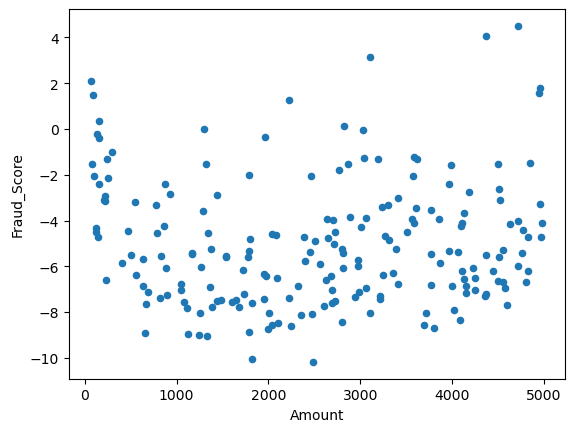

In [9]:
df.plot.scatter(x="Amount", y="Fraud_Score")

## Phase 4

###### -We’ll combine AML + Fraud results into a single dashboard that:
###### -Shows flagged transactions with color-coded risks
###### -Displays key metrics (total transactions, AML flags, fraud flags, overlaps)
###### -Allows drill-down on high-risk items

In [10]:
import pandas as pd
import streamlit as st
import plotly.express as px

# ------------------------------------------------------------
# Load and Prepare Data
# ------------------------------------------------------------
@st.cache_data
def load_data():
    df = pd.read_csv(r"N:\fintech_ai_project_blinkAI\data\transactions_fraud_detected.csv")
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    return df

df = load_data()

# ------------------------------------------------------------
# Sidebar Filters
# ------------------------------------------------------------
st.sidebar.title("🔍 Filter Transactions")
currency = st.sidebar.multiselect("Currency", df["Currency"].unique())
channel = st.sidebar.multiselect("Channel", df["Channel"].unique())
risk_threshold = st.sidebar.slider("Risk Threshold", 0, 100, 70)

filtered = df.copy()
if currency:
    filtered = filtered[filtered["Currency"].isin(currency)]
if channel:
    filtered = filtered[filtered["Channel"].isin(channel)]

# ------------------------------------------------------------
# Overview KPIs
# ------------------------------------------------------------
st.title("💼 Real-Time Fraud & AML Detection Dashboard")
st.markdown("Prototype inspired by **Blink AI Payments** (Bliink™ AML Pro + Fraud Pro).")

total_tx = len(filtered)
aml_flags = filtered["Flag_AML"].sum()
fraud_flags = filtered["Flag_Fraud"].sum()
combined_flags = ((filtered["Flag_AML"] == 1) | (filtered["Flag_Fraud"] == 1)).sum()

col1, col2, col3 = st.columns(3)
col1.metric("Total Transactions", f"{total_tx:,}")
col2.metric("AML Flags", aml_flags)
col3.metric("Fraud Flags", fraud_flags)

st.metric("Combined Risk Alerts", combined_flags)

# ------------------------------------------------------------
# Risk Distribution Visualization
# ------------------------------------------------------------
fig1 = px.histogram(
    filtered,
    x="AML_Risk_Score",
    color="Flag_AML",
    nbins=20,
    title="AML Risk Score Distribution",
)
st.plotly_chart(fig1, use_container_width=True)

fig2 = px.scatter(
    filtered,
    x="Amount",
    y="Fraud_Score",
    color=filtered["Flag_Fraud"].map({0: "Normal", 1: "Anomalous"}),
    title="Fraud Risk vs Transaction Amount",
)
st.plotly_chart(fig2, use_container_width=True)

# ------------------------------------------------------------
# High-Risk Transactions Table
# ------------------------------------------------------------
st.subheader("🚨 High-Risk Transactions")
high_risk = filtered[
    (filtered["AML_Risk_Score"] >= risk_threshold)
    | (filtered["Flag_Fraud"] == 1)
].sort_values(by=["AML_Risk_Score", "Fraud_Score"], ascending=False)

st.dataframe(
    high_risk[
        [
            "TxId",
            "Sender",
            "Receiver",
            "Amount",
            "Currency",
            "Country",
            "Purpose",
            "Channel",
            "AML_Risk_Score",
            "Fraud_Score",
            "Flag_AML",
            "Flag_Fraud",
        ]
    ],
    use_container_width=True,
)

# ------------------------------------------------------------
# Footer
# ------------------------------------------------------------
st.markdown(
    """
    ---
    **Note:**  
    This prototype demonstrates how ISO 20022 transaction data can be analyzed in real-time using
    hybrid AI + rule-based detection for compliance and fraud prevention.
    """
)


2025-10-21 10:51:44.078 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-21 10:51:47.123 
  command:

    streamlit run C:\Users\kokko\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-10-21 10:51:47.136 No runtime found, using MemoryCacheStorageManager


DeltaGenerator()

## Phase-5
###### -Explainability — use SHAP to show which features drive a transaction’s fraud score (global and per-transaction).
###### -Continuous learning (feedback loop) — simulate analyst feedback / labels, retrain a supervised model, and show how the model updates (simple transfer-like loop).

In [11]:
# src/prepare_labels_and_train_rf.py
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
import os

DATA_PATH = r"N:\fintech_ai_project_blinkAI\data\transactions_fraud_detected.csv"
MODEL_PATH = r"N:\fintech_ai_project_blinkAI\models\rf_fraud_model.joblib"

def load_and_encode(path=DATA_PATH):
    df = pd.read_csv(path)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Features for fraud detection
    features = ["Amount", "Country", "Purpose", "Channel", "AML_Risk_Score"]
    df_sub = df[features].copy()

    # Label encode categorical columns
    encoders = {}
    for col in ["Country", "Purpose", "Channel"]:
        le = LabelEncoder()
        df_sub[col] = le.fit_transform(df_sub[col].astype(str))
        encoders[col] = le

    return df, df_sub, encoders

def create_labels(df):
    # Use existing Flag_Fraud as proxy labels
    if "Flag_Fraud" in df.columns:
        labels = df["Flag_Fraud"].copy()
    else:
        labels = pd.Series(0, index=df.index)

    # Flip a small subset to simulate corrections / feedback
    rng = np.random.default_rng(42)
    flip_idx = rng.choice(df.index, size=int(0.01 * len(df)), replace=False)
    labels.loc[flip_idx] = 1 - labels.loc[flip_idx]

    return labels

def train_and_save(X, y, model_path=MODEL_PATH):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=7,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    joblib.dump(model, model_path)
    print("✅ Trained and saved Random Forest model to", model_path)

    return model

if __name__ == "__main__":
    df, X, encoders = load_and_encode()
    y = create_labels(df)
    model = train_and_save(X, y)


✅ Trained and saved Random Forest model to N:\fintech_ai_project_blinkAI\models\rf_fraud_model.joblib


<Figure size 1000x600 with 0 Axes>

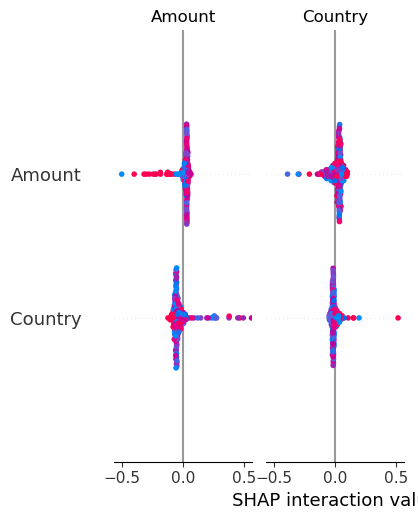

<Figure size 1200x800 with 0 Axes>

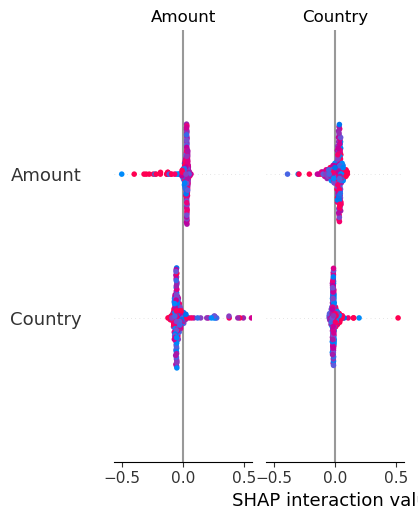

✅ Saved global SHAP importance CSV → N:\fintech_ai_project_blinkAI\data\shap_outputs\global_shap_importance.csv


In [63]:
import joblib
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# -------------------------
# Paths
# -------------------------
MODEL_PATH = r"N:\fintech_ai_project_blinkAI\models\rf_fraud_model.joblib"
DATA_PATH = r"N:\fintech_ai_project_blinkAI\data\transactions_fraud_detected.csv"
OUTPUT_DIR = r"N:\fintech_ai_project_blinkAI\data\shap_outputs"

# -------------------------
# Load Model
# -------------------------
model = joblib.load(MODEL_PATH)

# -------------------------
# Load & Prepare Data
# -------------------------
df = pd.read_csv(DATA_PATH)
X = df[["Amount", "Country", "Purpose", "Channel", "AML_Risk_Score"]].copy()

# Encode categorical features on the fly
for col in ["Country", "Purpose", "Channel"]:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# -------------------------
# SHAP Explainability
# -------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# -------------------------
# Display Professional Plots
# -------------------------
top_features = 10  # top N features to display

# 1️⃣ Global Feature Importance (Bar Plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X,
    plot_type="bar",
    max_display=top_features
)

# 2️⃣ SHAP Dot Summary (Per-row Contributions)
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X,
    plot_type="dot",
    max_display=top_features,
    color=plt.get_cmap("coolwarm")
)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------
# Load Model & Encoders
# -------------------------
model = joblib.load(MODEL_PATH)

# shap_values_list shape: (n_samples, n_features, n_classes)
# Select positive class (index 1)
shap_values_pos = shap_values[:, :, 1]  # shape now (200, 5)

# Compute mean absolute SHAP per feature
mean_abs_shap = np.abs(shap_values_pos).mean(axis=0)  # shape (5,)

# Create DataFrame
importance_df = pd.DataFrame({
    "feature": X.columns.tolist(),
    "mean_abs_shap": mean_abs_shap
})

# Save CSV
csv_path = os.path.join(OUTPUT_DIR, "global_shap_importance.csv")
importance_df.to_csv(csv_path, index=False)
print(f"✅ Saved global SHAP importance CSV → {csv_path}")
